In [38]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pprint

detector_path = '..'
sys.path.append(detector_path)

from sleep.mass import MASS
from sleep.mass import KEY_EEG, KEY_PAGES, KEY_ID, KEY_MARKS
from sleep.data_ops import seq2inter, inter2seq, seq2inter_with_pages
from evaluation.metrics import by_sample_confusion, by_sample_iou, by_event_confusion, matching
from sleep import postprocessing

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Example of postprocessing

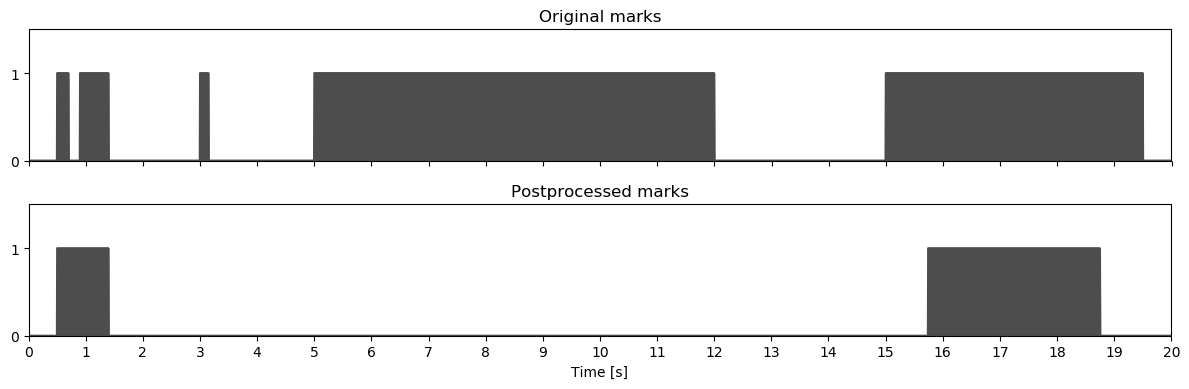

In [48]:
fs = 200
demo_marks = np.zeros(4000)

# Close marks
dur1 = 0.2
dur2 = 0.5
dist = 0.2
start = 100
demo_marks[start:(start + int(dur1*fs))] = 1
demo_marks[(start + int((dur1+dist)*fs)):(start + int((dur1+dist+dur2)*fs)) ] = 1

# Short and isolated mark
dur = 0.15
start = 600
demo_marks[start:(start + int(dur*fs))] = 1

# Too large mark (probably something went wrong)
dur = 7
start = 1000
demo_marks[start:(start + int(dur*fs))] = 1

# Too large mark, where we keep the central 3 s
dur = 4.5
start = 3000
demo_marks[start:(start + int(dur*fs))] = 1

# First, we need to translate the binary sequence to intervals
postprocess_marks = seq2inter(demo_marks)
# Then, we can postprocess
postprocess_marks = postprocessing.combine_close_marks(marks=postprocess_marks, fs=fs, min_separation=0.3)
postprocess_marks = postprocessing.filter_duration_marks(marks=postprocess_marks, fs=fs, min_duration=0.3, max_duration=3.0)
# Now, we return to a binary sequence
postprocess_marks = inter2seq(postprocess_marks, 0, 4000-1)

time_axis = np.arange(4000) / fs
fig, ax = plt.subplots(2, 1, figsize=(12, 4), dpi=100, sharex=True)
ax[0].plot(time_axis, demo_marks, color='0.3')
ax[0].fill_between(time_axis, demo_marks, color='0.3')
ax[0].set_title('Original marks')
ax[0].set_yticks([0, 1])
ax[0].set_ylim([0, 1.5])

ax[1].plot(time_axis, postprocess_marks, color='0.3')
ax[1].fill_between(time_axis, postprocess_marks, color='0.3')
ax[1].set_title('Postprocessed marks')
ax[1].set_xlim(time_axis[0], time_axis[-1])
ax[1].set_xlabel('Time [s]')
ax[1].set_xticks([i for i in range(21)])
ax[1].set_yticks([0, 1])
ax[1].set_ylim([0, 1.5])
plt.tight_layout()
plt.show()

## Example of IoU values

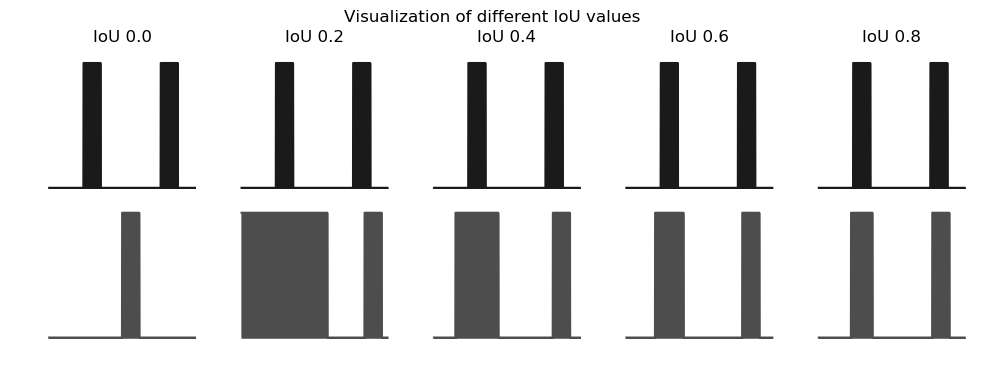

In [104]:

iou_array = [0.2, 0.4, 0.6, 0.8]
n_examples = len(iou_array) + 1
fig, ax = plt.subplots(1, n_examples, figsize=(12, 4), dpi=100)

for single_ax in ax:
    single_ax.axis('off')

size = 1700
center_1 = 500
center_2 = 1400
dur = 200
    
common_x_axis = np.arange(size)

# Zero Iou
y_axis_1 = np.zeros(size)
y_axis_2 = np.zeros(size)
y_axis_1[(center_1 - dur//2):(center_1 + dur//2)] = 1
y_axis_1[(center_2 - dur//2):(center_2 + dur//2)] = 1
y_axis_2[((center_1+center_2)//2 - dur//2):((center_1+center_2)//2 + dur//2)] = 1

ax[0].set_title('IoU %1.1f' % 0)
ax[0].plot(common_x_axis, y_axis_1+1.2, color='0.1')
ax[0].fill_between(common_x_axis, 1.2*np.ones(size), y_axis_1+1.2, color='0.1')
ax[0].plot(common_x_axis, y_axis_2, color='0.3')
ax[0].fill_between(common_x_axis, y_axis_2, color='0.3')

for i, iou in enumerate(iou_array):
    y_axis_1 = np.zeros(size)
    y_axis_2 = np.zeros(size)
    # First example
    # iou = dur1 / dur2 when dur1 is inside dur2
    y_axis_1[(center_1 - dur//2):(center_1 + dur//2)] = 1
    second_dur = int((dur/iou)//2)
    y_axis_2[(center_1 - second_dur):(center_1 + second_dur)] = 1
    # Second example
    # iou = (dur - offset) / (dur + offset)
    y_axis_1[(center_2 - dur//2):(center_2 + dur//2)] = 1
    offset = int(dur * (1 - iou) / (1+iou))
    y_axis_2[(center_2 - dur//2 + offset):(center_2 + dur//2 + offset)] = 1
    ax[i+1].set_title('IoU %1.1f' % iou)
    ax[i+1].plot(common_x_axis, y_axis_1+1.2, color='0.1')
    ax[i+1].fill_between(common_x_axis, 1.2*np.ones(size), y_axis_1+1.2, color='0.1')
    ax[i+1].plot(common_x_axis, y_axis_2, color='0.3')
    ax[i+1].fill_between(common_x_axis, y_axis_2, color='0.3')
    
fig.suptitle('Visualization of different IoU values')
plt.show()
